In [13]:
# Import required modules
from datetime import date
#from moeximporter import MoexImporter, MoexSecurity, MoexCandlePeriods
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import requests
from scipy import optimize

In [27]:
api_key = '659c220d967ba1.28407049'  # Replace with your actual API key
assets = ['SBER.MCX', 'NVTK.MCX', 'YNDX.MCX', 'LKOH.MCX']
start_date = '2014-01-01'
end_date = '2023-12-31'
pf_data = pd.DataFrame()

for t in assets:
    url = f'https://eodhistoricaldata.com/api/eod/{t}?from={start_date}&to={end_date}&api_token={api_key}&fmt=json'
    response = requests.get(url)
    
    # Check the response status code
    if response.status_code != 200:
        print(f"Failed to get data for {t}: Status code {response.status_code}")
        continue

    try:
        data = response.json()
        df = pd.DataFrame(data)
        df = df.set_index('date')
        pf_data[t] = df['adjusted_close']  # Assuming you want adjusted close prices
    except ValueError as e:
        print(f"Failed to parse JSON for {t}: {e}")

print(pf_data)

            SBER.MCX   NVTK.MCX  YNDX.MCX   LKOH.MCX
date                                                
2014-01-06   59.3171   271.4434       NaN   743.3639
2014-01-08   59.0585   268.1553       NaN   730.6632
2014-01-09   58.9202   265.8459       NaN   739.3296
2014-01-10   59.7862   267.0178       NaN   744.4472
2014-01-13   60.2854   273.6700       NaN   747.4730
...              ...        ...       ...        ...
2023-12-25  271.6000  1485.0000    2380.0  6760.0000
2023-12-26  271.9100  1479.0000    2420.0  6745.0000
2023-12-27  271.5500  1451.0000    2517.4  6775.5000
2023-12-28  272.0000  1455.8000    2547.0  6785.0000
2023-12-29  271.8000  1464.4000    2549.0  6768.0000

[2521 rows x 4 columns]


<Axes: xlabel='date'>

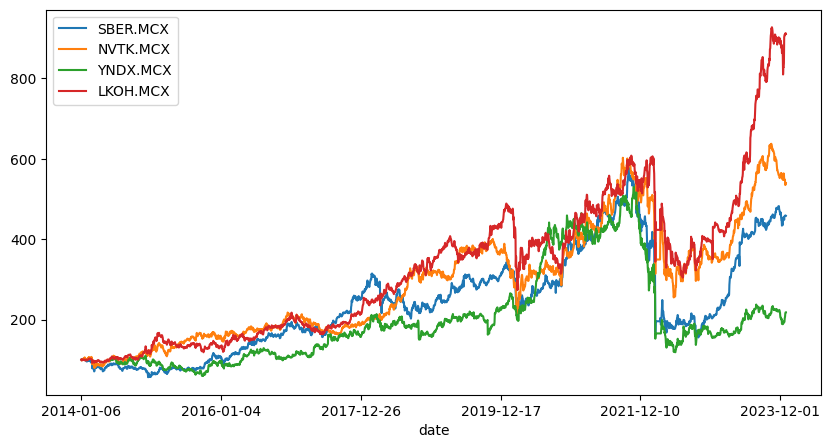

In [28]:
#This method handles each stock individually, normalizing it based on its first available data point.
normalized_data = pf_data.apply(lambda col: col / col.dropna().iloc[0] * 100)
normalized_data.plot(figsize=(10, 5))

In [29]:
log_returns = np.log (pf_data/pf_data.shift(1))
num_assets = len(assets)

pfolio_returns = []
pfolio_volatilities = []
pfolio_sharps = []
pfolio_weights = []

for x in range(5000):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_weights.append(weights)
    pfolio_returns.append(np.sum(weights * log_returns.mean())* 250)
    pfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov()*250, weights))))
    pfolio_sharps.append(pfolio_returns[x]/pfolio_volatilities[x])
    
pfolio_weights = np.array(pfolio_weights)
pfolio_returns = np.array(pfolio_returns)
pfolio_volatilities = np.array(pfolio_volatilities)
pfolio_sharps = np.array(pfolio_sharps)

In [30]:
max_st = pfolio_sharps.max()
ind_sr = pfolio_sharps.argmax()
max_sr_ret = pfolio_returns[ind_sr]
max_sr_vol = pfolio_volatilities[ind_sr]

In [31]:
pfolios = pd.DataFrame({'Return': pfolio_returns, 'Volatility': pfolio_volatilities, 'Sharp ratio' : pfolio_sharps})
pfolios

,Return,Volatility,Sharp ratio
0,0.154163,0.312073,0.493994
1,0.139702,0.306176,0.456279
2,0.168727,0.297737,0.566699
3,0.131925,0.309608,0.426103
4,0.185231,0.301429,0.614510
...,...,...,...
4995,0.139799,0.313933,0.445314
4996,0.133885,0.309892,0.432037
4997,0.166573,0.303817,0.548268
4998,0.133695,0.304877,0.438523


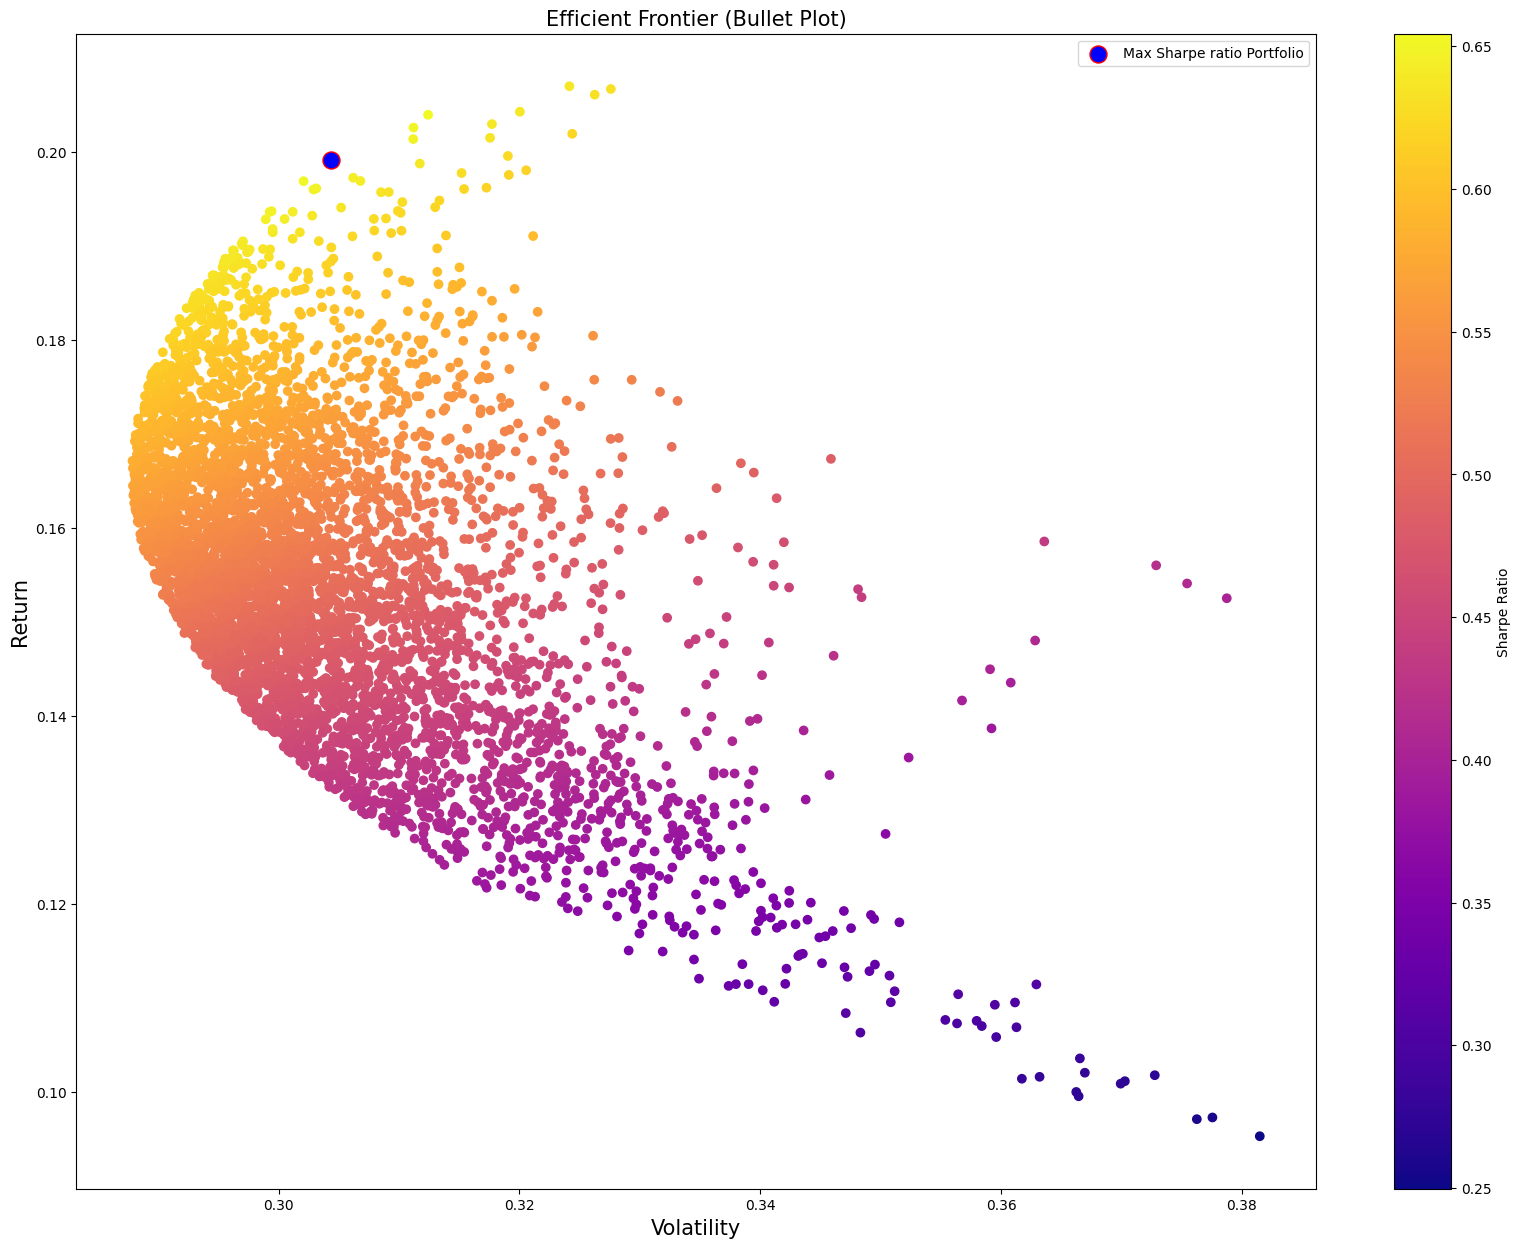

In [32]:
plt.figure(figsize=(20,15))
plt.scatter(pfolio_volatilities, pfolio_returns, c= pfolio_sharps, cmap ='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();

In [33]:
for weight, asset in zip(pfolio_weights[ind_sr],assets):
    print(f'{round(weight * 100, 2)} % of {asset} should be bought.')
    
print(f'\nMarkowitz optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility {max_sr_vol}')

3.7 % of SBER.MCX should be bought.
32.45 % of NVTK.MCX should be bought.
0.42 % of YNDX.MCX should be bought.
63.42 % of LKOH.MCX should be bought.

Markowitz optimal portfolio return is : 19.92% with volatility 0.3043618089026746


In [34]:
#SciPy optimization

# Some helper functions
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(weights * log_returns.mean())* 250
    vol = np.sqrt(np.dot(weights.T,np.dot(log_returns.cov()*250, weights)))
    sr = ret / vol
    return np.array([ret,vol,sr])
# Negate Sharpe ratio as we need to max it but Scipy minimizes the given function
def neg_sr(weights):
    return get_ret_vol_sr(weights)[-1] * -1

# Constraints for the optimization problem

def check_sum(weights):
    return np.sum(weights) - 1

cons = {'type':'eq','fun':check_sum}

# bounds on weights
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess for optimization to start with
init_guess = [(100/num_assets * 0.01) for _ in range(num_assets)]

# Call minimizer
opt_results = optimize.minimize(neg_sr, init_guess, constraints=cons, bounds=bounds, method='SLSQP')

In [35]:
optimal_weights = opt_results.x

print('Weights Using SciPy optimizer:\n')
for st, i in zip(assets,optimal_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')
    
print('\n')

print('Weights Monte Carlo:\n')
mc_weights = pfolio_weights[ind_sr]
for st, i in zip(assets,mc_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')

Weights Using SciPy optimizer:

Stock SBER.MCX has weight 0.0 %
Stock NVTK.MCX has weight 29.22 %
Stock YNDX.MCX has weight 0.0 %
Stock LKOH.MCX has weight 70.78 %


Weights Monte Carlo:

Stock SBER.MCX has weight 3.7 %
Stock NVTK.MCX has weight 32.45 %
Stock YNDX.MCX has weight 0.42 %
Stock LKOH.MCX has weight 63.42 %


In [36]:
print('For a given portfolio we have: (Using SciPy optimizer)\n')
for i, j in enumerate('Return Volatility SharpeRatio'.split()):
    print(f'{j} is : {get_ret_vol_sr(optimal_weights)[i]}')

print('\n')
    
print('For a given portfolio we have: (Using Monte Carlo)\n')
for i, j in enumerate('Return Volatility SharpeRatio'.split()):
    print(f'{j} is : {get_ret_vol_sr(mc_weights)[i]}')

For a given portfolio we have: (Using SciPy optimizer)

Return is : 0.2039517010885073
Volatility is : 0.3101942042815962
SharpeRatio is : 0.6574968141679355


For a given portfolio we have: (Using Monte Carlo)

Return is : 0.19916601529868544
Volatility is : 0.3043618089026746
SharpeRatio is : 0.6543725575056379


In [37]:
# Frontier Curve - Best return for given volatility or vice versa.

#generates 100 evenly spaced numbers between the minimum and maximum of pfolio_returns.
#These values (frontier_y) represent different target returns that you will use to construct the efficient frontier.
frontier_y = np.linspace(pfolio_returns.min(), pfolio_returns.max(), 100) 
frontier_vol = []

def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

for possible_ret in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
            {'type':'eq','fun':lambda w:get_ret_vol_sr(w)[0] - possible_ret})
    result = optimize.minimize(minimize_vol, init_guess, method='SLSQP', constraints=cons, bounds=bounds)
    frontier_vol.append(result.fun)

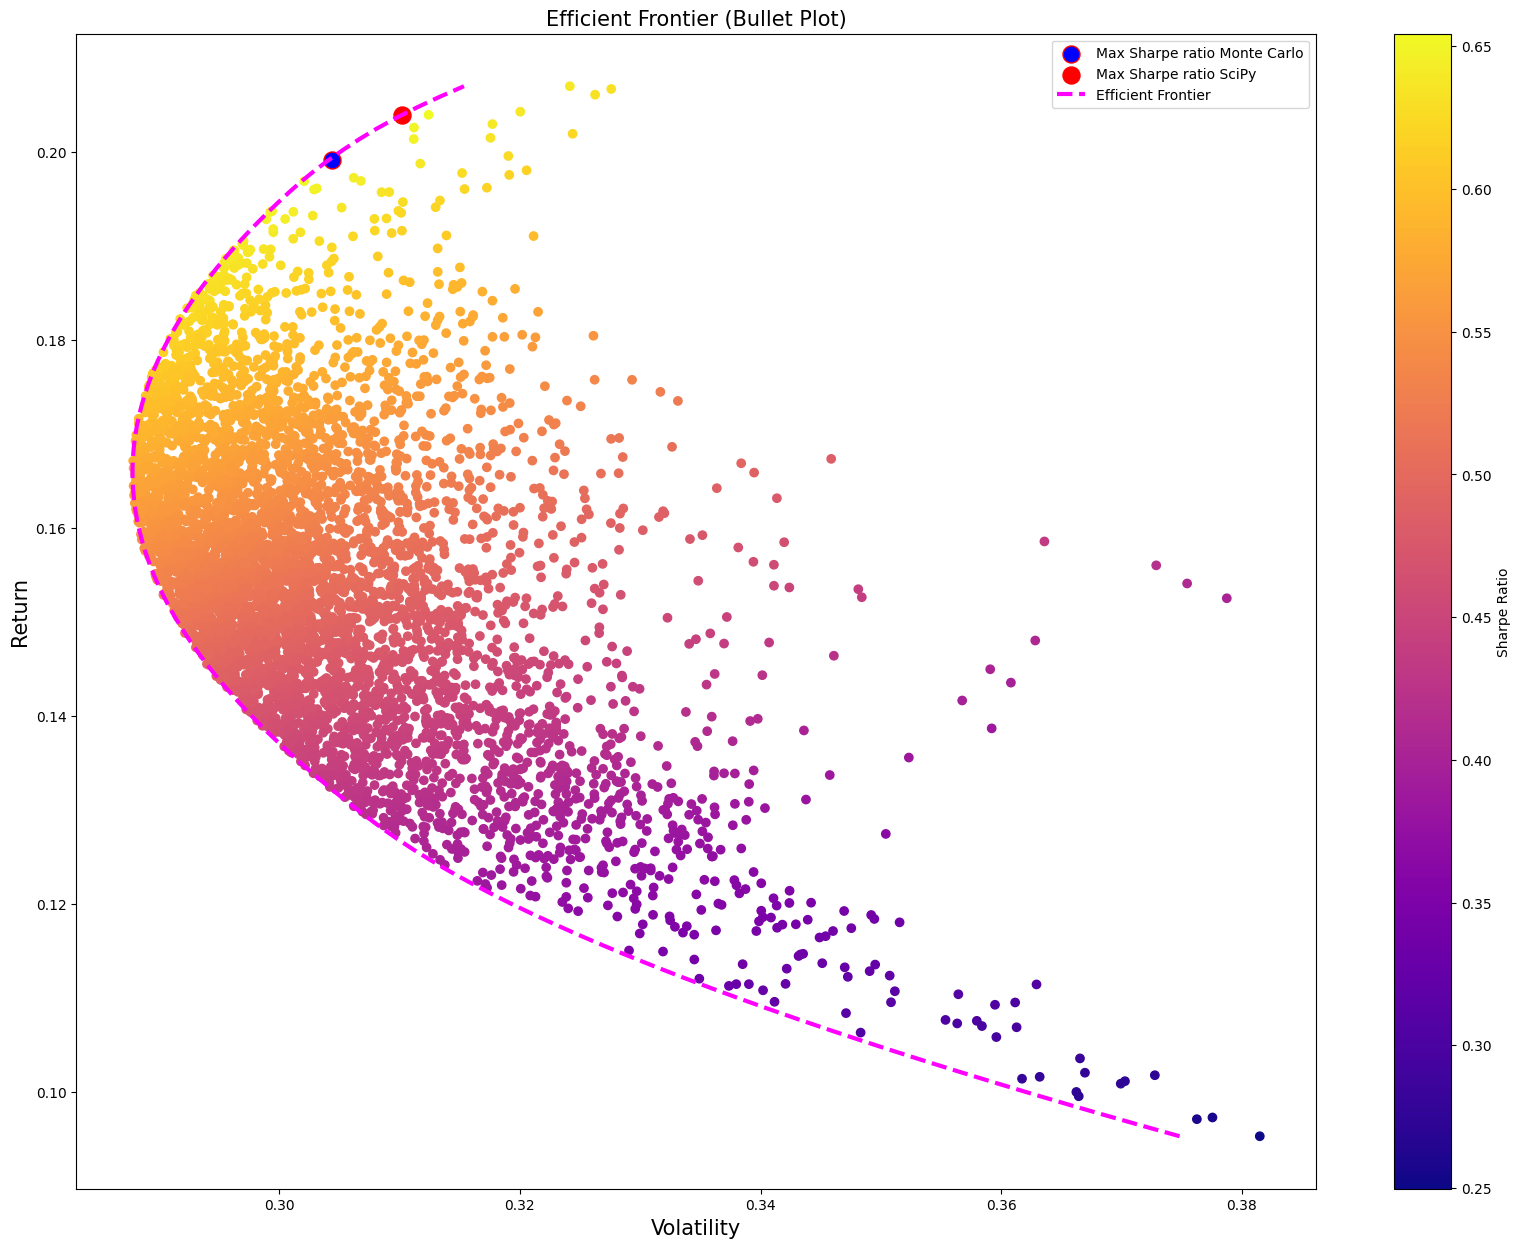

In [38]:
plt.figure(figsize=(20,15))
plt.scatter(pfolio_volatilities, pfolio_returns, c= pfolio_sharps, cmap ='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Monte Carlo')
plt.scatter(get_ret_vol_sr(optimal_weights)[1], get_ret_vol_sr(optimal_weights)[0], c='red', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio SciPy')
plt.plot(frontier_vol, frontier_y, c='magenta', ls='--', lw=3, label='Efficient Frontier')
plt.legend();

In [39]:
max_sr_ret/max_sr_vol

0.6543725575056379

In [32]:
""" What I need to do next

1)conditions for stocks: 
no more than 10% in portfolio
condition for liquidity of the stock
stock should exist more than 4 years on the market

2)download all stocks availaible for conditions above

3)to make a solution that allows to find returns ans Sharp Ratio based on your desired volatility

4)hide the API token

5)check all the variable names make sense
"""

' What I need to do next\n1)conditions for stocks: \nno more than 10%\nliquidity enough\nmore than 4 years on the market\n\n2)download all stocks availaible for conditions above\n\n3)to make a solution that allows to find returns ans SR based on your desired volatility\n\n4)hide the API token\n\n5)check all the variable names make sense\n'